In [21]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score, precision_score
from matplotlib import pyplot as  plt
import concurrent.futures
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('HW_TESLA.xlt')

In [3]:
def splitDataSet7525(df):
    """
    This function is to generate dataset for cross validation with 25% data available
    """
    df_train, df_test = train_test_split(df, test_size=0.25) # 75 % training data   
    return df_train, df_test

In [4]:
def splitDataSet5050(df):
    """
    This function is to generate dataset for held out validation of 25% data available
    """
    df_train, X = train_test_split(df, test_size=0.5) # 50 % training data   
    df_val, df_test = train_test_split(X, test_size=0.5) # 25 % validation data and 25 % testing data
    return df_train, df_val, df_test

In [5]:
def balanceSplit(df):
    """
    This function is to generate balanced dataset for held out validation of 25% data available
    """
    X_train = pd.concat([df[df['STATIC']==0].sample(n=1037), df[df['STATIC']==1].sample(n=1038)])
    idx = [i for i in range(4150) if i not in X_train.index] # Getting row indices which are not in X_train    
    df1 = df.iloc[idx]
    X_val = pd.concat([df1[df1['STATIC']==0].sample(n=518), df1[df1['STATIC']==1].sample(n=519)])
    idx = [i for i in range(2075) if i not in X_val.index] # Getting row indices which are not in X_val
    X_test = df1.iloc[idx]
    return X_train, X_val, X_test
    

In [6]:
def generate_data():
    df = pd.read_excel('HW_TESLA.xlt')
    global X_train, y_train, X_test, y_test
    df_train, df_test = splitDataSet7525(df)
    #Separating feature matrix and corresponding labels
    X_train = df_train.drop('STATIC',axis=1)
    # X_val = df_val.drop('STATIC',axis=1)
    X_test = df_test.drop('STATIC',axis=1)
    y_train = df_train['STATIC']
    # y_val = df_val['STATIC']
    y_test = df_test['STATIC']
    return X_train, y_train, X_test, y_test

In [7]:
def generate_report(conf_mat, y_test, y_pred):

    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)

    return FP, FN, accuracy, recall, precision, f1score

In [46]:
def DT_before_PCA():
    X_train, y_train, X_test, y_test = generate_data()
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train,y_train)

    random_grid = {'criterion': ['gini','entropy'],
                   'max_depth': [2,3,4,5,6,7],
                   'min_samples_split':[2,3,4,5],
                   }
    clf = DecisionTreeClassifier()
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid)
    clf_random.fit(X_train, y_train)
    #     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, X_train, y_train, cv=3)
    val_score = (scores.mean(), scores.std() * 2)

    y_pred = clf_random.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, val_score[0])
    
    return outcome

### Calculating n_components in PCA for feature reduction

[ 64.2  92.7  99.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100. ]


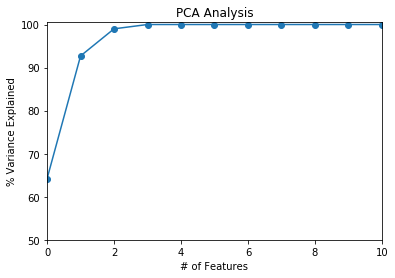

In [13]:
#Centering data by mean i.e. subtracting mean from each data and doing PCA

# scaler=StandardScaler().fit(X_train)
# X_train=scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test=scaler.transform(X_test)

covar_matrix=PCA()
covar_matrix.fit(X_train)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
print(var) #cumulative sum of variance explained with [n] features

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(50,100.5)
plt.xlim(0,10)
plt.style.context('seaborn-whitegrid')


plt.plot(var, marker='o')

In [14]:
def apply_PCA():
    global pca_X_train, pca_X_test
    # we can reduce number of features to 5 to capture 99.8 % variance in PCA
    pca=PCA(n_components=5)
    pca.fit(X_train)

    # Get new feature matrices from pca
    pca_X_train=pca.transform(X_train)
    pca_X_test=pca.transform(X_test)

### Generating Datasets for all experiments

In [51]:
X_train, y_train, X_test, y_test = generate_data()

### Running Decision Tree Algorithm after PCA

In [48]:
def DT_after_PCA():
    X_train, y_train, X_test, y_test = generate_data()
    apply_PCA()
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train,y_train)

    random_grid = {'criterion': ['gini','entropy'],
                   'max_depth': [2,3,4,5,6,7],
                   'min_samples_split':[2,3,4,5],
                   }
    clf = DecisionTreeClassifier()
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid)
    clf_random.fit(X_train, y_train)
    #     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, X_train, y_train, cv=3)
    val_score = (scores.mean(), scores.std() * 2)

    y_pred = clf_random.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, val_score[0])
    
    return outcome

### Running Logistic Regression after PCA

In [16]:
def LR_after_PCA():
    X_train, y_train, X_test, y_test = generate_data()
    apply_PCA()
    clf = LogisticRegression()
    clf.fit(pca_X_train,y_train)

    # Trying ShuffleSplit
    cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf, pca_X_train, y_train, cv=cv)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
    
    return outcome

### Running Linear SVM after PCA

In [17]:
def SVM_after_PCA():
    X_train, y_train, X_test, y_test = generate_data()
    apply_PCA()
    
    clf = SVC(kernel='linear')
    clf.fit(pca_X_train,y_train)

    # Trying ShuffleSplit
    cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf, pca_X_train, y_train, cv=cv)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
    
    return outcome
    

In [18]:
def RF_after_PCA():
    
    X_train, y_train, X_test, y_test = generate_data()
    apply_PCA()
    
    def evaluate(model, test_features, test_labels):
        predictions = model.predict(test_features)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = 100 - mape
        print('Model Performance')
        print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
        print('Accuracy = {:0.2f}%.'.format(accuracy))

        return accuracy
    
    clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
    clf.fit(pca_X_train,y_train)
    base_accuracy = evaluate(clf, pca_X_test, y_test)
    
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
    max_features = ['auto', 'sqrt']
    max_depth = list(range(1,10,1))
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split':min_samples_split,
                   'bootstrap': bootstrap}
    
    clf = RandomForestClassifier()
    clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
                                  n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    clf_random.fit(pca_X_train,y_train)
    best_random = clf_random.best_estimator_
    random_accuracy = evaluate(best_random, pca_X_test, y_test)
    
    # Trying ShuffleSplit
    cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, pca_X_train, y_train, cv=cv)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf_random.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
    print(clf_random.best_params_)
    print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
    return outcome

### Getting the report of different algorithms

In [50]:
algos = {'Decision Tree before PCA':DT_before_PCA,
         'Decision Tree with PCA':DT_after_PCA,
         'Logistic Regression':LR_after_PCA,
         'SVM':SVM_after_PCA}

for k in algos.keys():
    count = 1000 # Experiment Count for analysis
    algo = algos[k]
    start = time.perf_counter()
    val_scores = np.array([])
    p_scores = np.array([])
    measurements = []

    for _ in range(count):
        outcome = algo()
        measurements.append(outcome)
   
  
#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         results = [executor.submit(algo) for _ in range(count)]

#     for f in concurrent.futures.as_completed(results):
#         outcome = f.result()
#         measurements.append(outcome)

    print("\n\n\nRan the experiment with", k , count, "times")
    print("Report: \n")
    cols = ['Val_Accuracy', 'FP', 'FN', 'Accuracy', 'Recall', 'Precision', 'F1Score']
    df_outcome = pd.DataFrame(measurements, columns=cols)
    print(df_outcome)

    finish = time.perf_counter()
    print("Averaging the above experiments: \n")
    print(df_outcome.mean())
    print("Time Taken for execution is ", round(finish-start, 2), 'Seconds')




Ran the experiment with Decision Tree before PCA 1000 times
Report: 

     Val_Accuracy  FP  FN  Accuracy    Recall  Precision   F1Score
0        0.994218   0   2  0.998073  0.996890   1.000000  0.998442
1        0.991002   1   1  0.998073  0.998392   0.998392  0.998392
2        0.993252   5   7  0.988439  0.988710   0.991909  0.990307
3        0.993573   1   5  0.994220  0.992051   0.998400  0.995215
4        0.992287   5   0  0.995183  1.000000   0.992390  0.996180
..            ...  ..  ..       ...       ...        ...       ...
995      0.993572   7   1  0.992293  0.998400   0.988906  0.993631
996      0.994856   5   6  0.989403  0.990164   0.991790  0.990976
997      0.992609   4   1  0.995183  0.998382   0.993559  0.995964
998      0.991967   4   1  0.995183  0.998410   0.993671  0.996035
999      0.991645   5   2  0.993256  0.996885   0.992248  0.994561

[1000 rows x 7 columns]
Averaging the above experiments: 

Val_Accuracy    0.993227
FP              2.644000
FN           